# Extending Intake-ESM

So far, ``intake-esm`` supports dataset collections from the following projects:

- CMIP5 & CMIP6
- CESM1-LE
- CESM1-LE on AWS
- NA-CORDEX
- ERA5
- GMET
- MPIGE

In case your dataset collection of choice isn't on the list above, ``intake-esm`` makes it easy to add support for it. 

This tutorial documents how to add support for a new dataset collection. For this tutorial, we will be adding support for [NA-Cordex data](https://na-cordex.org/) to intake-esm. 

The following steps will be replicable for your dataset collection of choice:

## Step 1: Select Attributes 

Suppose your dataset of choice consistes of thousands of files, and these files are named according to some convention/tempate. To add support for this kind of dataset to ``intake-esm``, you will need to understand the formatting and attributes of your dataset, file name template and/or directory structure. For example, each netCDF file in the NA-CORDEX collection is named according to this template:

``[variable].[experiment].[global_climate_model].[regional_climate_model].[frequency].[grid].[bias_corrected_or_raw].nc``.



## Step 2: Generate a `collection_name.yaml` Configuration File

Once you've decided what attributes describe your dataset collection, the next step is to generate a configuration `YAML` file with information about the colum headings to be used when `intake-esm` generates a local database for all file in your dataset collection.  This YAML file should be housed inside the `intake_esm/collection_defs` folder:


```bash
../../../intake_esm/
├── aggregate.py
├── bld_collection_utils.py
├── cesm_aws.py
├── cesm.py
├── cli.py
├── cmip.py
├── collection_defs
│   ├── cesm-aws.yaml
│   ├── cesm.yaml
│   ├── cmip.yaml
│   ├── cordex.yaml
│   ├── gmet.yaml
│   ├── mpige.yaml
│   └── sources.yaml
├── collection.py
├── config.py
├── config.yaml
├── core.py
├── era5.py
├── gmet.py
├── __init__.py
├── mpige.py  
├── source.py
└── storage.py
```

For our cordex data the full file path is: `intake_esm/collection_defs/cordex.yaml` and has the following content:

```yaml
collections:
  cordex:
    collection_columns:
    - resource
    - resource_type
    - direct_access
    - variable
    - experiment 
    - global_climate_model
    - regional_climate_model    
    - frequency
    - grid
    - bias_corrected_or_raw
    - file_fullpath
    - file_basename
    - file_dirname
    order_by_columns:
      - file_fullpath
    required_columns:
      - file_fullpath
```   

Here is a description of all of the assigned keys in our `intake_esm/collection_defs/cordex.yaml` file:

- **cordex**: the name of our new dataset collection 
- **collection_columns**: list of column headings to be used for our local database. Among the list of column headings, `resource`, `resource_type`, `direct_access` are required because they are used by ``intake-esm`` for different purposes:
  - `resource`: used to generate a key that helps to differentiate data files that may reside in two different locations. For example, a file may exists both on a local posix filesystem and a remote tape. 
  - `resource_type`: used for describing the storage type (is it a posix filesytem, tape, object storage (e.g. S3, etc...)
  - `direct_access`: depending on the storage type, you may be required to move data to a different system and/or storage system before doing actual computation. This column specifies whether a file can be accessed directly or whether it should be transferred to a different system first. 

  - Other column headings were generated according to **Step 1**
- **order_by_column**: list of columns to use when ordering the files in the local database
- **required_columns**: list of columns that are absolutely necessary. This list is used by `intake-esm` internally. 


Your YAML file should follow the same template as above, but with the items listed under `collection_columns`, `order_by_columns`, `required_columns` appropriate for your dataset collection.

## Step 3: Create a `collection_name.py` Module Containing Rules for Gathering Attributes

Inside the `intake-esm/intake_esm` directory:
    

```bash
../../../intake_esm/
├── aggregate.py
├── bld_collection_utils.py
├── cesm_aws.py
├── cesm.py
├── cli.py
├── cmip.py
├── collection_defs
│   ├── cesm-aws.yaml
│   ├── cesm.yaml
│   ├── cmip.yaml
│   ├── cordex.yaml
│   ├── gmet.yaml
│   ├── mpige.yaml
│   └── sources.yaml
├── collection.py
├── config.py
├── config.yaml
├── cordex.py
├── core.py
├── era5.py
├── gmet.py
├── __init__.py
├── mpige.py  
├── source.py
└── storage.py
```

    
create a new `collection_name.py` file, here called `cordex.py`. This file contains the rules for filling the columns (determined by the `cordex.yaml` file in Step 2) via the information found in each data file name.

Inside the `cordex.py` module, we will create two classes that subclasses **Collection** and **BaseSource** classes. For our use case, we name our two classes `CORDEXCollection` and `CORDEXSource`.


### Step 3a: Writing the Collection Class

The Collection Class, in our script called `CORDEXCollection` inherits from base `Collection` class, but we still have to implement the `_get_file_attrs()` method that determines how to get attributes from filename.

This is the starting point, any formatting will have at least this skeleton of a structure: 


```python
""" Implementation for The NA-CORDEX data holdings """
import os

from tqdm.auto import tqdm

from . import aggregate, config
from .bld_collection_utils import _ensure_file_access, _reverse_filename_format, get_subset
from .collection import Collection, docstrings
from .source import BaseSource

class CORDEXCollection(Collection):

    __doc__ = docstrings.with_indents(
        """ Builds a NA-CORDEX collection for data
        stored on NCAR's GLADE
    %(Collection.parameters)s
    """
    )

    def _get_file_attrs(self, filepath):
        file_basename = os.path.basename(filepath)
        fs = file_basename.split('.')

        keys = list(set(self.columns) - set(['resource', 'resource_type', 'direct_access']))

        fileparts = {key: None for key in keys}
        fileparts['file_basename'] = file_basename
        fileparts['file_dirname'] = os.path.dirname(filepath) + '/'
        fileparts['file_fullpath'] = filepath

       
        return fileparts
```


In our method, within the `_get_file_attrs()` method, we define a `filename_templat`' to retrieve the attribute components of the filename. Then the `_reverse_filename_format()` function maps these attributes to the collection columns.

```python
class CORDEXCollection(Collection):

    __doc__ = docstrings.with_indents(
        """ Builds a NA-CORDEX collection for data
        stored on NCAR's GLADE
    %(Collection.parameters)s
    """
    )

    def _get_file_attrs(self, filepath):
        file_basename = os.path.basename(filepath)
        fs = file_basename.split('.')

        keys = list(set(self.columns) - set(['resource', 'resource_type', 'direct_access']))

        fileparts = {key: None for key in keys}
        fileparts['file_basename'] = file_basename
        fileparts['file_dirname'] = os.path.dirname(filepath) + '/'
        fileparts['file_fullpath'] = filepath
        
        filename_template = '{variable}.{experiment}.{global_climate_model}.{regional_climate_model}.{frequency}.{grid}.{bias_corrected_or_raw}.nc'
        
        f = _reverse_filename_format(file_basename, filename_template)
        fileparts.update(f)
            
        return fileparts
```

For example, the output of fileparts from the file `uas_hist_CanESM2_CRCM5-UQAM_day_NAM-44i_raw.nc` looks like:

```python
{'variable': 'uas',
 'experiment': 'hist',
 'global_climate_model': 'CanESM2',
 'regional_climate_model': 'CRCM5-UQAM',
 'frequency': 'day',
 'grid': 'NAM-44i',
 'bias_corrected_or_raw': 'raw'}
```

**Not Done Yet! Now go into `intake_esm/core.py` and add the following lines:**


- Near the top of the script you will find a list of importing Collection classes from each data type's .py modules.  So now we add:

```python
from .cordex import CORDEXCollection
```

-  Then you will find a `collecton_types` dictionary:

```python
    collection_types = {
        'cesm': CESMCollection,
        'cesm-aws': CESMAWSCollection,
        'cmip5': CMIP5Collection,
        'cmip6': CMIP6Collection,
        'mpige': MPIGECollection,
        'gmet': GMETCollection,
        'era5': ERA5Collection,
    }
 ```
    
- Add an entry for your new collection:

```python
    collection_types = {
        'cesm': CESMCollection,
        'cesm-aws': CESMAWSCollection,
        'cmip5': CMIP5Collection,
        'cmip6': CMIP6Collection,
        'mpige': MPIGECollection,
        'gmet': GMETCollection,
        'era5': ERA5Collection,
        'cordex': CORDEXCollection,
    }
 ```

### Step 3b: Writing the Source Class

The Source Class, in our `cordex.py` module called `CORDEXSource`. For this class, we need to implement the required `_open_dataset()` method. It is in this method that we define the logic to use when loading different data files into xarray datasets.  

First you need to make some decisions about what **dataset fields(column headings)** consitute a unique dataset. These fields informs `intake-esm` about which column headings to use when concatenating and merging different data files togethe (you probably wouldn't put data gridded differently in the same dataset, for example). In our case we chose 6 columns: 

- `global_climate_model`
- `regional_climate_model`
- `frequency`
- `grid`
- `bias_corrected_or_raw`
- `experiment`



Below we have the CORDEXSource class:

```python
class CORDEXSource(BaseSource):
    name = 'cordex'
    partition_access = True

    def _open_dataset(self):
        # fields which define a single dataset
        dataset_fields = [
            'global_climate_model',
            'regional_climate_model',
            'frequency',
            'grid',
            'bias_corrected_or_raw',
            'experiment',
        ]

        kwargs = self._validate_kwargs(self.kwargs)

        all_dsets = {}
        ds = get_subset(self.collection_name, self.query)

        file_fullpath_column_name = 'file_fullpath'
        file_basename_column_name = 'file_basename'
        variable_column_name = 'variable'

        df = _ensure_file_access(ds, file_fullpath_column_name, file_basename_column_name)
        grouped = df.groupby(dataset_fields)
        for dset_keys, dset_files in tqdm(
            grouped, desc='dataset', disable=not config.get('progress-bar')
        ):
            dset_id = '.'.join(dset_keys)
            var_dsets = []
            for v_id, v_files in dset_files.groupby(variable_column_name):
                urlpath_ei_vi = v_files[file_fullpath_column_name].tolist()
                dsets = [
                    aggregate.open_dataset_delayed(
                        url,
                        data_vars=[v_id],
                        chunks=kwargs['chunks'],
                        decode_times=kwargs['decode_times'],
                    )
                    for url in urlpath_ei_vi
                ]

                var_dset_i = aggregate.concat_time_levels(
                    dsets,
                    time_coord_name_default=kwargs['time_coord_name'],
                    override_coords=kwargs['override_coords'],
                )
                var_dsets.append(var_dset_i)

            _dset_i = aggregate.merge(dsets=var_dsets)
            all_dsets[dset_id] = _dset_i

        self._ds = all_dsets
```

For more utility functions that can be used to construct xarray datasets, look inside `aggregate.py` module to understand more of the built-in functionality.

**Now go into `collection_defs/source.yaml` and add the new Source class to the list of sources:**

It should look like this:

```python
sources:
  cesm: intake_esm.cesm.CESMSource
  cesm-aws: intake_esm.cesm_aws.CESMAWSSource
  cmip5: intake_esm.cmip.CMIP5Source
  cmip6: intake_esm.cmip.CMIP6Source
  mpige: intake_esm.mpige.MPIGESource
  gmet: intake_esm.gmet.GMETSource
  era5: intake_esm.era5.ERA5Source
  cordex: intake_esm.cordex.CORDEXSource
```

## Step 4: Create a Collection Input YAML File

This file is an external input, not a part of the package, just external input. We named it `cordex-collection-input.yaml`.

This YAML file requires the following keys: **name**, **collection_type**, and **data_sources**.


Here is a description of all of the assigned keys in our cordex-collection-input.yaml file:

- **name** - What is a meaninful name for your dataset. In this example, this is `NA-CORDEX`

- **collection_type** - This should match the name of your new dataset collection defined in Step 2 and 3.  Here it is `cordex`.

- **data_sources**. - Where should intake-esm look for your data? This can point to more than one directory, but in this example we have only one key, here named `CORDEX-Data`. Within the data_source `CORDEX-DATA` we point to locations. `locations` is list of dictionaries, each with the following keys:

    - **name** - For us, all of our data is on the GLADE file storage system so we name this location 'GLADE.' **It is very important that the combination of your data_source key and location key are unique**, so the combination of `CORDEX-Data` and `GLADE` should not be repeated inside this YAML file.

    - **loc_type** - How is this data stored? Typically data is on a posix file system, but if the data is on Tape or Cloud Storage, you might have a different answer here. So far, ``intake-esm`` supports the following types:
      - posix: For Posix storage
      - hsi: For HPSS tape storage using `hsi` interface
      - aws-s3: For AWS S3 Object storage

    - **direct_access** - Here this is set to `True` because our data can be accessed directly. If your data were on tape storage, this would be set to `False`. 

    - **urlpath** - The path to a directory that contains your data. If data does not share a root directory, you will want to have several items in the locations list.
    
Below is what our collection input YAML file looks like for the cordex data:

```yaml
name: NA-CORDEX
collection_type: cordex
data_sources:
  CORDEX-Data:
    locations:
      - name: GLADE
        loc_type: posix
        direct_access: True
        urlpath: /glade/collections/cdg/data/cordex/data/
```

Here we display how intake-esm will interpret the structure of that yaml file. This maybe easier to understand for some.

```python
{'name': 'NA-CORDEX',
 'collection_type': 'cordex',
 'data_sources': {'CORDEX-Data': {'locations': [{'name': 'GLADE',
     'loc_type': 'posix',
     'direct_access': True,
     'urlpath': '/glade/collections/cdg/data/cordex/data/'}]}}}
```

## Step 5: Testing

**Congratulations! You have added a new dataset collection to the intake-esm ecosystem!**

Let's test the collection:

In [15]:
%matplotlib inline
import intake
import yaml


- **Let's generate our collection catalog**

In [2]:
test = yaml.safe_load('''name: NA-CORDEX
collection_type: cordex
data_sources:
  CORDEX-Data:
    locations:
      - name: GLADE
        loc_type: posix
        direct_access: True
        urlpath: /glade/collections/cdg/data/cordex/data/''')        

test

{'name': 'NA-CORDEX',
 'collection_type': 'cordex',
 'data_sources': {'CORDEX-Data': {'locations': [{'name': 'GLADE',
     'loc_type': 'posix',
     'direct_access': True,
     'urlpath': '/glade/collections/cdg/data/cordex/data/'}]}}}

In [3]:
col = intake.open_esm_metadatastore(collection_input_definition=test, overwrite_existing=True)

Getting file listing: CORDEX-Data:GLADE:posix:/glade/collections/cdg/data/cordex/data/



Persisting NA-CORDEX at : /glade/u/home/abanihi/.intake_esm/collections/NA-CORDEX.nc


- **Let's explore our new collection catalog**

In [4]:
col.df.head()

,resource,resource_type,direct_access,variable,experiment,global_climate_model,regional_climate_model,frequency,grid,bias_corrected_or_raw,file_fullpath,file_basename,file_dirname
index,,,,,,,,,,,,,
0,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,hurs,rcp85,CNRM-CM5,CRCM5-OUR,ymon,NAM-22,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,hurs.rcp85.CNRM-CM5.CRCM5-OUR.ymon.NAM-22.raw.nc,/glade/collections/cdg/data/cordex/data/raw/NA...
1,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,hurs,hist,MPI-ESM-LR,WRF,ann,NAM-44i,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,hurs.hist.MPI-ESM-LR.WRF.ann.NAM-44i.raw.nc,/glade/collections/cdg/data/cordex/data/raw/NA...
2,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,hurs,rcp85,MPI-ESM-LR,WRF,ann,NAM-44i,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,hurs.rcp85.MPI-ESM-LR.WRF.ann.NAM-44i.raw.nc,/glade/collections/cdg/data/cordex/data/raw/NA...
3,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,hurs,hist,MPI-ESM-MR,CRCM5-UQAM,mon,NAM-22i,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,hurs.hist.MPI-ESM-MR.CRCM5-UQAM.mon.NAM-22i.ra...,/glade/collections/cdg/data/cordex/data/raw/NA...
4,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,hurs,eval,ERA-Int,WRF,ann,NAM-44i,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,hurs.eval.ERA-Int.WRF.ann.NAM-44i.raw.nc,/glade/collections/cdg/data/cordex/data/raw/NA...


In [5]:
col

NA-CORDEX collection catalogue with 17166 entries:
	> 1 resource(s)

	> 1 resource_type(s)

	> 1 direct_access(s)

	> 18 variable(s)

	> 5 experiment(s)

	> 10 global_climate_model(s)

	> 7 regional_climate_model(s)

	> 10 frequency(s)

	> 5 grid(s)

	> 4 bias_corrected_or_raw(s)

	> 17166 file_fullpath(s)

	> 17068 file_basename(s)

	> 17166 file_dirname(s)

In [6]:
col.ds

<xarray.Dataset>
Dimensions:                 (index: 17166)
Coordinates:
  * index                   (index) int64 0 1 2 3 4 ... 17162 17163 17164 17165
Data variables:
    resource                (index) object 'CORDEX-Data:GLADE:posix:/glade/collections/cdg/data/cordex/data/' ... 'CORDEX-Data:GLADE:posix:/glade/collections/cdg/data/cordex/data/'
    resource_type           (index) object 'posix' 'posix' ... 'posix' 'posix'
    direct_access           (index) bool True True True True ... True True True
    variable                (index) object 'hurs' 'hurs' 'hurs' ... 'vas' 'vas'
    experiment              (index) object 'rcp85' 'hist' ... 'eval' 'rcp85'
    global_climate_model    (index) object 'CNRM-CM5' 'MPI-ESM-LR' ... 'CanESM2'
    regional_climate_model  (index) object 'CRCM5-OUR' 'WRF' ... 'WRF' 'CanRCM4'
    frequency               (index) object 'ymon' 'ann' 'ann' ... 'ann' 'day'
    grid                    (index) object 'NAM-22' 'NAM-44i' ... 'NAM-44'
    bias_corrected_

In [7]:
col.unique(columns=['frequency', 'grid', 'experiment'])

{'frequency': {'count': 10,
  'values': ['ymon',
   'ann',
   'mon',
   'day',
   'yseas',
   'seas',
   'fixed',
   '3hr',
   '1hr',
   '6hr']},
 'grid': {'count': 5,
  'values': ['NAM-22', 'NAM-44i', 'NAM-22i', 'NAM-11', 'NAM-44']},
 'experiment': {'count': 5,
  'values': ['rcp85', 'hist', 'eval', 'rcp45', 'rcp26']}}

- **Search along attributes**

In [8]:
cat = col.search(variable = 'uas', global_climate_model ='CanESM2', regional_climate_model ='CRCM5-UQAM', 
                 experiment = 'hist', frequency = 'day', grid='NAM-44i')

In [9]:
cat.ds

<xarray.Dataset>
Dimensions:                 (index: 4)
Coordinates:
  * index                   (index) int64 14805 15092 15533 15737
Data variables:
    resource                (index) object 'CORDEX-Data:GLADE:posix:/glade/collections/cdg/data/cordex/data/' ... 'CORDEX-Data:GLADE:posix:/glade/collections/cdg/data/cordex/data/'
    resource_type           (index) object 'posix' 'posix' 'posix' 'posix'
    direct_access           (index) float64 1.0 1.0 1.0 1.0
    variable                (index) object 'uas' 'uas' 'uas' 'uas'
    experiment              (index) object 'hist' 'hist' 'hist' 'hist'
    global_climate_model    (index) object 'CanESM2' 'CanESM2' ... 'CanESM2'
    regional_climate_model  (index) object 'CRCM5-UQAM' ... 'CRCM5-UQAM'
    frequency               (index) object 'day' 'day' 'day' 'day'
    grid                    (index) object 'NAM-44i' 'NAM-44i' ... 'NAM-44i'
    bias_corrected_or_raw   (index) object 'mbcn-METDATA' ... 'kddm-METDATA'
    file_fullpath       

- **Load the search results into a dictionary of xarray datasets**

In [10]:
dset = cat.to_xarray(chunks={'time': 50})

<div class="alert alert-info">

**Note:** 
    

``to_xarray()`` method returns a dictionary of ``xarray`` datasets. For `cordex` collection catalog, the keys in this dictionary are constructed using the Step 3b, i.e ``key=<global_climate_model>.<regional_climate_model>.<frequency>.<grid>.<bias_corrected_or_raw>.<experiment>``
    
    
</div>
    
    

In [11]:
dset.keys()

dict_keys(['CanESM2.CRCM5-UQAM.day.NAM-44i.kddm-METDATA.hist', 'CanESM2.CRCM5-UQAM.day.NAM-44i.mbcn-METDATA.hist', 'CanESM2.CRCM5-UQAM.day.NAM-44i.raw.hist'])

In [13]:
ds = dset['CanESM2.CRCM5-UQAM.day.NAM-44i.raw.hist']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 129, lon: 300, time: 20440)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon        (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
    time_bnds  (time, bnds) object dask.array<shape=(20440, 2), chunksize=(50, 2)>
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 dask.array<shape=(20440, 129, 300), chunksize=(50, 129, 300)>
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 236x241 incl. 10p pilot a...
    geophysical_fields

/glade/work/abanihi/softwares/miniconda3/envs/intake-esm-dev/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


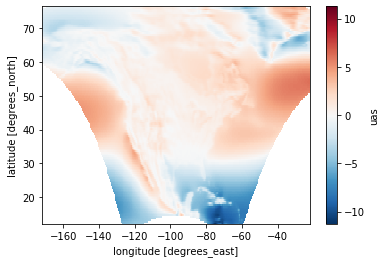

In [16]:
ds.uas.mean('time').plot()

## Step 6: Contribute to `intake-esm`

This step is optional, but for others to benefit from your great work, we recommend the following:

- Opening a pull request in `intake-esm` Github repository: https://github.com/NCAR/intake-esm. See the [contribution guide](https://intake-esm.readthedocs.io/en/latest/contributing.html) for more information 
- Adding your collection input YAML file defined in Step 4 to `intake-esm`'s list of curated dataset collection residing in https://github.com/NCAR/intake-esm-datastore